In [1]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests

/Users/vishaldawar/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/vishaldawar/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


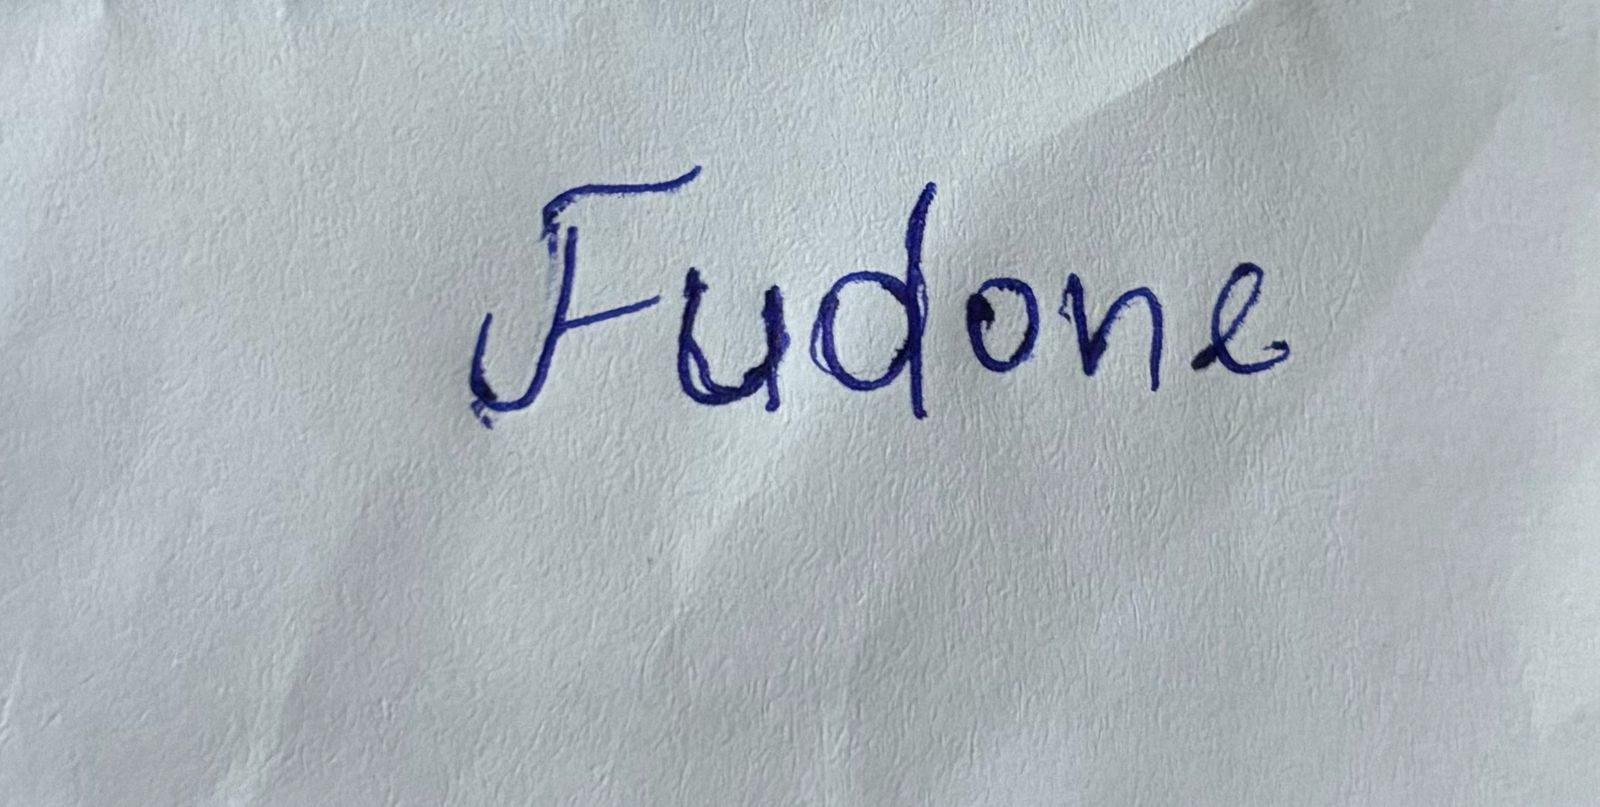

In [2]:
from IPython.display import Image as Image_ipython
# pil_img = Image_ipython(filename='./Sample-handwritten-text-input-for-OCR.png')
pil_img = Image_ipython(filename='./data/fudone_medicine.jpeg')
display(pil_img)

In [3]:
image = Image.open('./data/fudone_medicine.jpeg').convert("RGB")
image.show()

In [4]:
%%time
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')
print("Processor and model read!")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> i

Processor and model read!
CPU times: user 10.8 s, sys: 1.82 s, total: 12.6 s
Wall time: 7.17 s


In [5]:
%%time
pixel_values = processor(images=image, return_tensors="pt").pixel_values
print("Pixel values created, generating text!")
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

generated_text

Pixel values created, generating text!
CPU times: user 2.13 s, sys: 856 ms, total: 2.99 s
Wall time: 311 ms


'2 Evidence .'

In [6]:
import cv2
import pytesseract

In [7]:
def extract_text_from_cv2(path):
    # Load image
    image = cv2.imread(path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Extract text
    extracted_text = pytesseract.image_to_string(gray)
    
    print("Extracted Text:", extracted_text)


In [8]:
extract_text_from_cv2("./data/fudone_medicine.jpeg")

Extracted Text: Fudenz



In [1]:
import torch

torch.cuda.is_available()

False

In [2]:
print(torch.backends.mps.is_available())

True


In [9]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from tqdm.auto import tqdm
from urllib.request import urlretrieve
from zipfile import ZipFile
from PIL import ImageSequence

import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import glob
import cv2

device = torch.device('mps')

In [10]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-handwritten').to(device)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "deco

In [11]:


# device = torch.device('cpu')


def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.
    Returns:
        generated_text: the OCR'd text string.
    """
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values,max_new_tokens=100)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text



def eval_new_data(data_path=None, num_samples=4, model=None, num_lines=1,num_cols=1):
    image_paths = glob.glob(data_path)
    transcription = ''
    for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        if i == num_samples:
            break
        image = Image.open(image_path).convert('RGB')
        width, height = image.size
        line_height = height // num_lines  # replace num_lines with the number of lines in your image
        line_width = width // num_cols
        if num_lines == 1:
            text = ocr(image, processor, model)
            # plt.figure(figsize=(7, 4))
            # plt.imshow(image)
            # plt.title('\n'+ text)
            # plt.axis('off')
            # plt.show()
            transcription = text
        else:
            for j in range(num_lines):
                start = j * line_height
                end = (j + 1) * line_height
                for w in range(num_cols):
                    start_w = w * line_width
                    end_w = (w+1) * line_width
                    line_image = image.crop((start_w, start, end_w, end))
                    text = ocr(line_image, processor, model)
                    transcription += ' ' + text
                    # plt.figure(figsize=(7, 4))
                    # plt.imshow(line_image)
                    # plt.title(text)
                    # plt.axis('off')
                    # plt.show()
        print("Transcription : ",transcription)




In [12]:
eval_new_data(
    data_path=os.path.join("data","fudone_medicine.jpeg"),
    num_samples=1,
    model=model,
    num_lines=5,
    num_cols = 2
)

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]

Transcription :   1961 62minton 1961 62m. 0 . E. class # www movie 1961 62m. the other districts the other Westwood West Virginia
